In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
numLayer = 3
numQubit = 3
global iterations
global noisy

In [5]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 8):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

#unitary_param_1 = [2.10501732, 5.11015318, 1.02860258, 4.19873724, 4.92982797, 0.34386221, 0.36480756, 0.03715926, 
#                   0.26142496, 3.83355082, 2.72581293, 4.00028864]

In [6]:
print(unitary_param_1)

[1.8708157  3.80526752 4.80276646 1.06120479 1.19216353 3.18554626
 0.85818647 4.01581479]


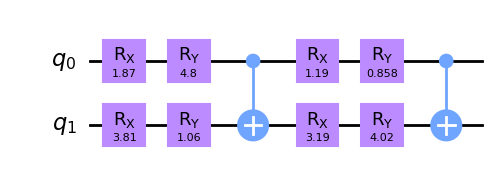

In [7]:
# First unitary
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [8]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [9]:
def createEqSuperposCS3SE():
    temp = QuantumCircuit(2)
    temp.ry(2*np.arctan(np.sqrt(2)), 1)
    temp.ch(1, 0)
    return temp

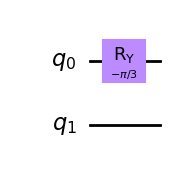

In [10]:
qcTest = QuantumCircuit(2)
qcTest.ry(-np.pi/3, 0)
qcTest.draw('mpl')

In [11]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(6)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCS3SE()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3, 4, 5])
    
    circ.ccx(0, 3, 2)
    circ.ccx(0, 5, 4)
    
    circ.ccx(0, 2, 3)
    circ.ccx(0, 4, 5)
    
    circ.ccx(1, 3, 2)
    circ.ccx(1, 5, 4)

    circ.ccx(1, 2, 3)
    circ.ccx(1, 4, 5)
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

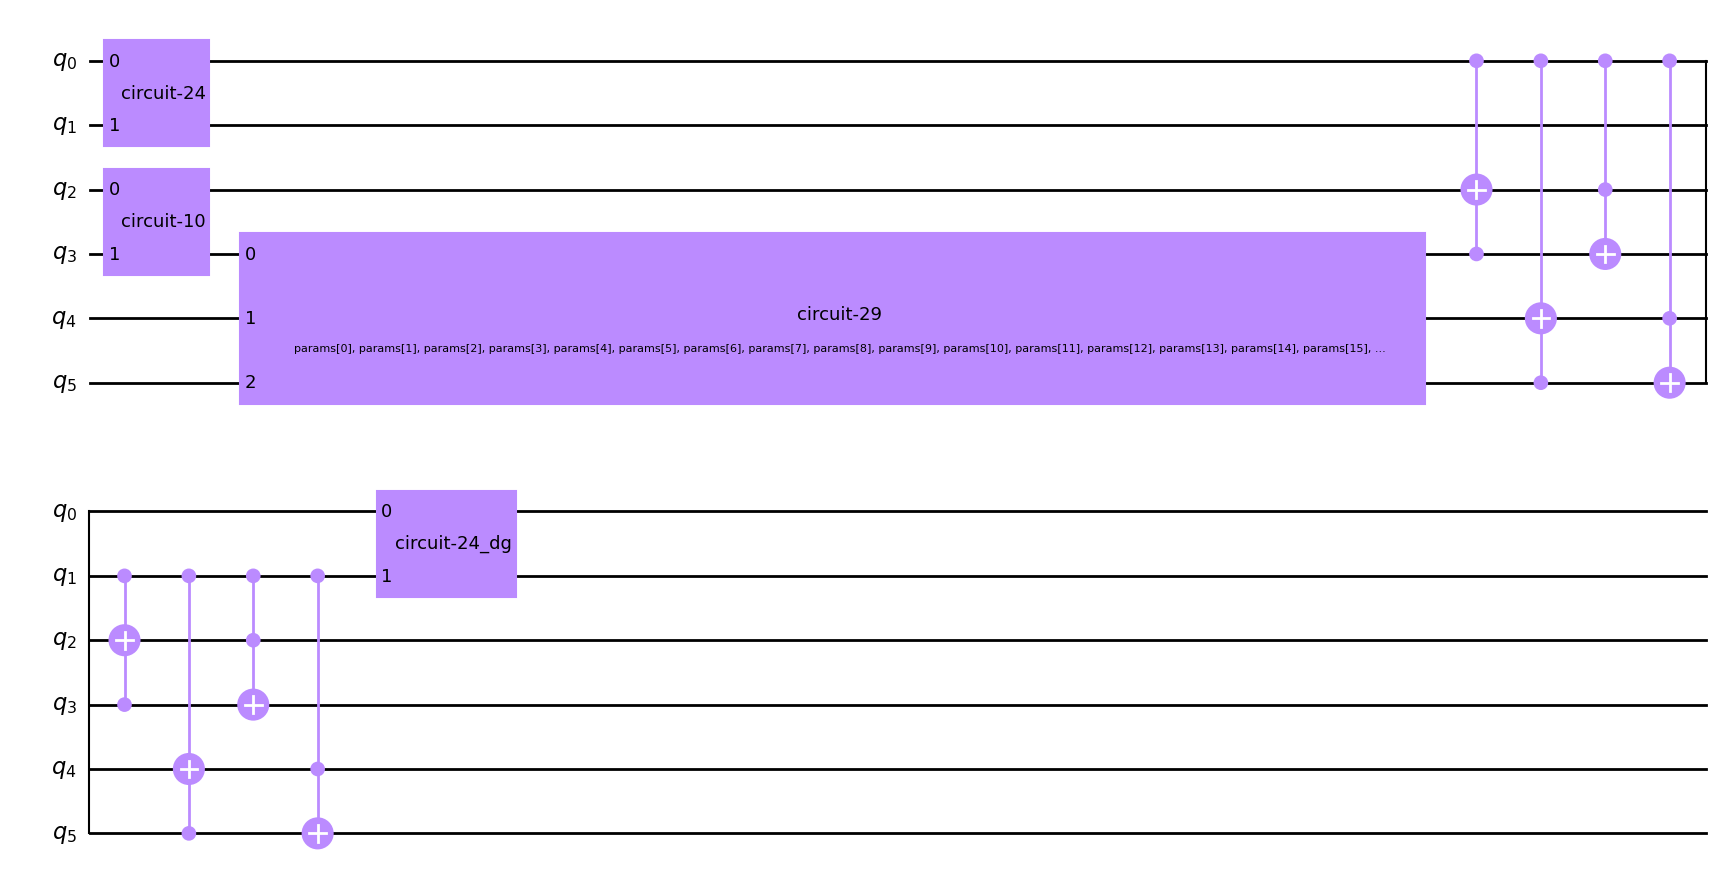

In [13]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [14]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [15]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [16]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [17]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [18]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [19]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17])])


In [20]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [21]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[2.31951696 0.89611531 4.19887547 5.72974531 0.69591467 2.08439296
 1.65296016 0.06266269 6.10474209 3.00468241 5.48496352 3.03360075
 1.28181974 3.51169076 0.39129535 3.12757034 0.36460587 5.42774681]
Initial Cost :  0.3589536800444762


In [22]:
true_value = 0.8383

In [78]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.35530340699100704
Loss Value :  0.35448107588787375 1.0%
Loss Value :  0.32072546486112485 2.0%
Loss Value :  0.41406480209808894 3.0%
Loss Value :  0.44323832561116183 4.0%
Loss Value :  0.4433767809060043 5.0%
Loss Value :  0.4533077533201567 6.0%
Loss Value :  0.46348397553885945 7.0%
Loss Value :  0.468368966187922 8.0%
Loss Value :  0.4746744739353395 9.0%
Loss Value :  0.4745747905849865 10.0%
Loss Value :  0.47822326690384515 11.0%
Loss Value :  0.47982239624055845 12.0%
Loss Value :  0.4805260745544425 13.0%
Loss Value :  0.4873160082365431 14.0%
Loss Value :  0.4892888940833381 15.0%
Loss Value :  0.4933870187133778 16.0%
Loss Value :  0.49863145119346747 17.0%
Loss Value :  0.5233679445344064 18.0%
Loss Value :  0.5346978455207738 19.0%
Loss Value :  0.5365976370053336 20.0%
Loss Value :  0.5503632145132566 21.0%
Loss Value :  0.5805111342967948 22.0%
Loss Value :  0.600727750216264 23.0%
Loss Value :  0.6317826337108046 24.0%
Loss Value :  0.636235449799578

In [79]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.3349220220444756
Loss Value :  0.35859398234078194 1.0%
Loss Value :  0.3465122272893408 2.0%
Loss Value :  0.3481040003827195 3.0%
Loss Value :  0.35944855706287315 4.0%
Loss Value :  0.38874516804001213 5.0%
Loss Value :  0.47325475620024343 6.0%
Loss Value :  0.5472756598917423 7.0%
Loss Value :  0.5108256001517266 8.0%
Loss Value :  0.5518431193117719 9.0%
Loss Value :  0.5457397842753978 10.0%
Loss Value :  0.5110307981429867 11.0%
Loss Value :  0.5298320915338038 12.0%
Loss Value :  0.5430010051802908 13.0%
Loss Value :  0.5588625393850333 14.0%
Loss Value :  0.5514513779190411 15.0%
Loss Value :  0.5290949632635732 16.0%
Loss Value :  0.5430711828445363 17.0%
Loss Value :  0.5255303362366935 18.0%
Loss Value :  0.5370508088530856 19.0%
Loss Value :  0.5286234318199701 20.0%
Loss Value :  0.523248843118943 21.0%
Loss Value :  0.5455760254300858 22.0%
Loss Value :  0.5347404699941434 23.0%
Loss Value :  0.5444538178597758 24.0%
Loss Value :  0.5459714024722401 25

In [80]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.8327061557641187


In [81]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.8383
Noiseless :  0.8322643919758203
Noisy :  0.5992245340132251
Noise Resilient Value :  0.8327061557641187


In [82]:
def writeToFile():
    file = open("CS3_GSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [83]:
writeToFile()